# Latent Factor Model

This notebook contains all experiments for the LFM

<a id=content><a>
## Table of contents
1. ## [Load data and set parameters](#load_data)
2. ## [Tune number of latent factors](#tune)
3. ## [Basic experiments](#basic_exps)
4. ## [Different number of negative samples](#neg_samples)
    ### [0.5x positive samples](#0.5)
    ### [2x positive samples](#2)
    ### [3x positive samples](#3)

In [ ]:
import sys

In [ ]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/gdrive')
    %cd gdrive/MyDrive/
    # ! rm -r LastFM/
    # ! git pull https://github.com/TimofeevAlex/LastFM.git
    sys.path.append('/content/gdrive/MyDrive/LastFM/src')
else:
    sys.path.append('src')

Mounted at /content/gdrive
/content/gdrive/MyDrive


In [ ]:
import os
import sys
from datetime import datetime
from tqdm import tqdm
tqdm.pandas()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from keras.utils.vis_utils import model_to_dot

from IPython.display import clear_output

from train_test import train_test_split
from models import create_shallow_model
from metrics import compute_metrics
from preprocessing import build_get_negative_ratings
from neumf_helpers import create_test_step, test_one_epoch, create_train_step, train_one_epoch, validate_one_epoch, plot_metrics
%load_ext autoreload
%autoreload 2

seed=0
np.random.seed(seed)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


<a id=load_data><a>
## Load data and set parameters

In [ ]:
train = pd.read_csv('lastfm-dataset-360K/train.csv')
valid = pd.read_csv('lastfm-dataset-360K/valid.csv')
test = pd.read_csv('lastfm-dataset-360K/test.csv')

In [ ]:
behav_data = pd.read_csv('lastfm-dataset-360K/behav-360k-processed.csv')
demo_data = pd.read_csv('lastfm-dataset-360K/demo-360k-processed.csv')

In [ ]:
num_artists = train['artist_id'].max()
num_users = demo_data['user_email'].max()

In [ ]:
batch_size = 2 ** 16
k=10
threshold = 0.1
epochs = 35
num_factors = 120

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices(test)
test_dataset = test_dataset.batch(batch_size)

<a id=tune><a>
## Tune number of latent factors

In [ ]:
factors = [20, 50, 100, 120, 160]
histories = []
precisions = []
recalls = []

labels = train.rating>=threshold
y = train.rating
weights = tf.expand_dims(1. + 0.25*y, -1)

for num_f in factors:
  model = create_shallow_model(num_f, num_users, num_artists)
  optimizer = tf.keras.optimizers.Adam()
  loss_fct = tf.keras.losses.BinaryCrossentropy(from_logits=False)
  model.compile(optimizer = optimizer, loss = loss_fct, metrics = tf.keras.metrics.RootMeanSquaredError())

  history = model.fit(x=[train.user_email, train.artist_id],
                      y=labels,
                      sample_weight=weights,
                      epochs = epochs,
                      batch_size=batch_size,
                      validation_data=([valid.user_email, valid.artist_id],
                                       valid.rating>=threshold),
                      verbose = 0)
  
  histories.append(history)

  # compute test loss and metrics

  test_loss_avg = tf.keras.metrics.Mean()
  test_rmse = tf.keras.metrics.RootMeanSquaredError()

  test_step = create_test_step(model, loss_fct, test_loss_avg, test_rmse)
  probs, test_loss, test_rmse = test_one_epoch(test_step, test_dataset, None, test_loss_avg, test_rmse, threshold, si=False, only_si=False)
  
  print('num_factors:', num_f)
  print('Test loss:', test_loss)
  print('Test RMSE:', test_rmse)

  pred_ratings = test.copy()
  pred_ratings['pred'] = probs
  pred_ratings_dict = {}
  for user, user_df in pred_ratings.groupby('user_email'):
    pred_ratings_dict[user] = np.stack([user_df['artist_id'].to_numpy(), user_df['pred'].to_numpy()])
  prec, rec, _, _, _  = compute_metrics(test.drop(test[test.rating == 0].index), test['user_email'].unique(), pred_ratings_dict, k)

  precisions.append(np.mean(prec))
  recalls.append(np.mean(rec))

  

num_factors: 20
Test loss: 0.20973614
Test RMSE: 0.24717438
Computing precision & recall...



Computing normalized discounted cumulative gain...



Computing hit rate...



Computing average reciprocal hit ranking...




Metrics: 

Precision @ 10: 0.32879057458547023
Recall    @ 10: 0.6677970950175771
Ndcg @ 10: 0.6952605896256442
Hit rate: 3.269874258032684
Arhr: 1.3428868381623713
num_factors: 50
Test loss: 0.18041736
Test RMSE: 0.22614205
Computing precision & recall...



Computing normalized discounted cumulative gain...



Computing hit rate...



Computing average reciprocal hit ranking...




Metrics: 

Precision @ 10: 0.33952573897701965
Recall    @ 10: 0.690018469611565
Ndcg @ 10: 0.7074026954514266
Hit rate: 3.3766876485803565
Arhr: 1.4076803273376126
num_factors: 100
Test loss: 0.17408957
Test RMSE: 0.21996132
Computing precision & recall...



Computing normalized discounted cumulative gain...



Computing hit rate...



Computing average reciprocal hit ranking...




Metrics: 

Precision @ 10: 0.33824290178371186
Recall    @ 10: 0.6877252002317416
Ndcg @ 10: 0.7042663043376435
Hit rate: 3.363724713305324
Arhr: 1.3972644660930575
num_factors: 120
Test loss: 0.17299758
Test RMSE: 0.21798907
Computing precision & recall...



Computing normalized discounted cumulative gain...



Computing hit rate...



Computing average reciprocal hit ranking...




Metrics: 

Precision @ 10: 0.34096108129121
Recall    @ 10: 0.693163489131448
Ndcg @ 10: 0.7076588449336485
Hit rate: 3.3905775757666374
Arhr: 1.4105537174723424
num_factors: 160
Test loss: 0.17159142
Test RMSE: 0.21606085
Computing precision & recall...



Computing normalized discounted cumulative gain...



Computing hit rate...



Computing average reciprocal hit ranking...




Metrics: 

Precision @ 10: 0.3436344063513898
Recall    @ 10: 0.6985178129437508
Ndcg @ 10: 0.7127023872575071
Hit rate: 3.4171613115440396
Arhr: 1.42838448757573


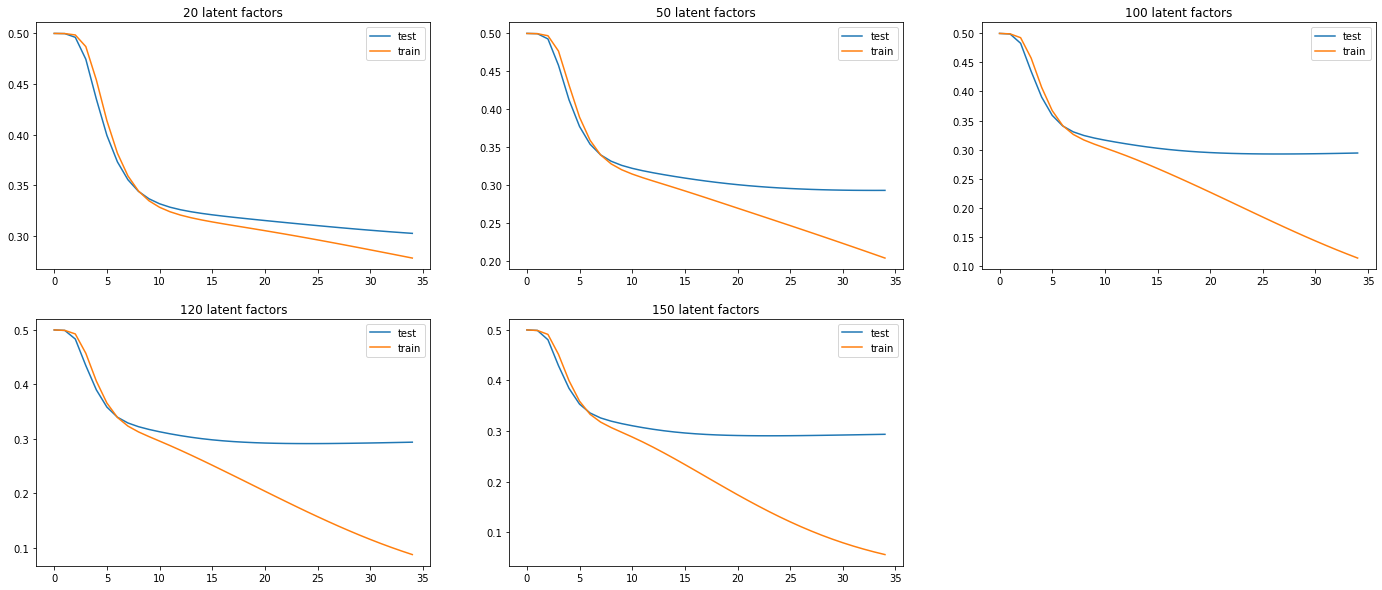

In [ ]:
# plot training details

plt.figure(figsize=(24, 10))

plt.subplot(231)
plt.plot(list(range(epochs)), histories[0].history['val_root_mean_squared_error'], label = 'test')
plt.plot(list(range(epochs)), histories[0].history['root_mean_squared_error'], label='train')
plt.title('20 latent factors')
plt.legend()

plt.subplot(232)
plt.plot(list(range(epochs)), histories[1].history['val_root_mean_squared_error'], label = 'test')
plt.plot(list(range(epochs)), histories[1].history['root_mean_squared_error'], label='train')
plt.title('50 latent factors')
plt.legend()

plt.subplot(233)
plt.plot(list(range(epochs)), histories[2].history['val_root_mean_squared_error'], label = 'test')
plt.plot(list(range(epochs)), histories[2].history['root_mean_squared_error'], label='train')
plt.title('100 latent factors')
plt.legend()

plt.subplot(234)
plt.plot(list(range(epochs)), histories[3].history['val_root_mean_squared_error'], label = 'test')
plt.plot(list(range(epochs)), histories[3].history['root_mean_squared_error'], label='train')
plt.title('120 latent factors')
plt.legend()

plt.subplot(235)
plt.plot(list(range(epochs)), histories[4].history['val_root_mean_squared_error'], label = 'test')
plt.plot(list(range(epochs)), histories[4].history['root_mean_squared_error'], label='train')
plt.title('150 latent factors')
plt.legend()

plt.savefig('plots/tuning_lfm')

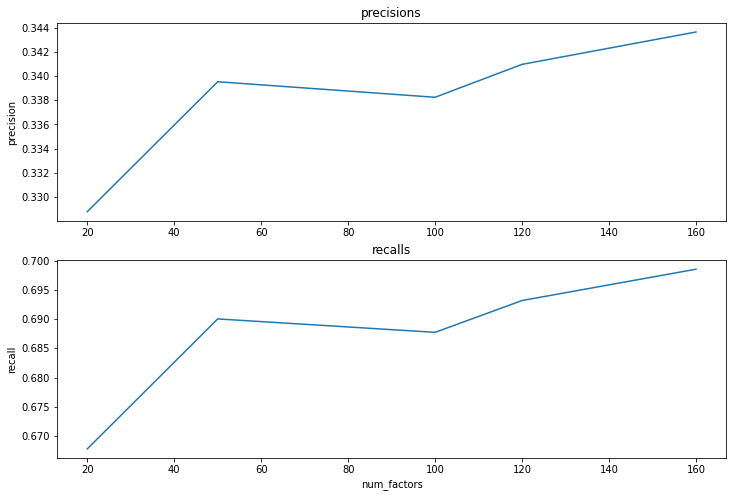

In [ ]:
# plot metrics

plt.figure(figsize=(12, 8))

plt.subplot(211)
plt.plot(factors, precisions)
plt.ylabel('precision')
plt.title('precisions')

plt.subplot(212)
plt.plot(factors, recalls)
plt.xlabel('num_factors')
plt.ylabel('recall')
plt.title('recalls')

plt.savefig('plots/tuning_lfm_metrics')

<a id=basic_exps><a>
## Basic Experiments

In [ ]:
# create model, define optimizer and loss function
model = create_shallow_model(num_factors, num_users, num_artists)
optimizer = tf.keras.optimizers.Adam()
loss_fct = tf.keras.losses.BinaryCrossentropy(from_logits=False)
model.compile(optimizer = optimizer, loss = loss_fct, metrics = tf.keras.metrics.RootMeanSquaredError())

In [ ]:
# set binary labels, calculate weights
labels = train.rating>=threshold
y = train.rating
weights = tf.expand_dims(1. + 0.25*y, -1)

# fit model
history = model.fit(x=[train.user_email, train.artist_id],
                      y=labels,
                      sample_weight=weights,
                      epochs = epochs,
                      batch_size=batch_size,
                      validation_data=([valid.user_email, valid.artist_id],
                                       valid.rating>=threshold),
                      verbose = 0)


avg_test_loss = tf.keras.metrics.Mean()
test_rmse = tf.keras.metrics.RootMeanSquaredError()

test_step = create_test_step(model, loss_fct, avg_test_loss, test_rmse)
probs, test_loss, test_rmse = test_one_epoch(test_step, test_dataset, None, avg_test_loss, test_rmse, threshold, si=False, only_si=False)
print('Test loss:', test_loss)
print('Test RMSE:', test_rmse)

pred_ratings = test.copy()
pred_ratings['pred'] = probs
pred_ratings_dict = {}
for user, user_df in pred_ratings.groupby('user_email'):
  pred_ratings_dict[user] = np.stack([user_df['artist_id'].to_numpy(), user_df['pred'].to_numpy()])
prec, rec, _, _, _  = compute_metrics(test.drop(test[test.rating == 0].index), test['user_email'].unique(), pred_ratings_dict, k)

Test loss: 0.17219235
Test RMSE: 0.21780927
Computing precision & recall...



Computing normalized discounted cumulative gain...



Computing hit rate...



Computing average reciprocal hit ranking...




Metrics: 

Precision @ 10: 0.3410059357385285
Recall    @ 10: 0.6933688268689316
Ndcg @ 10: 0.7105050804260417
Hit rate: 3.3910709746871404
Arhr: 1.4139616646361437


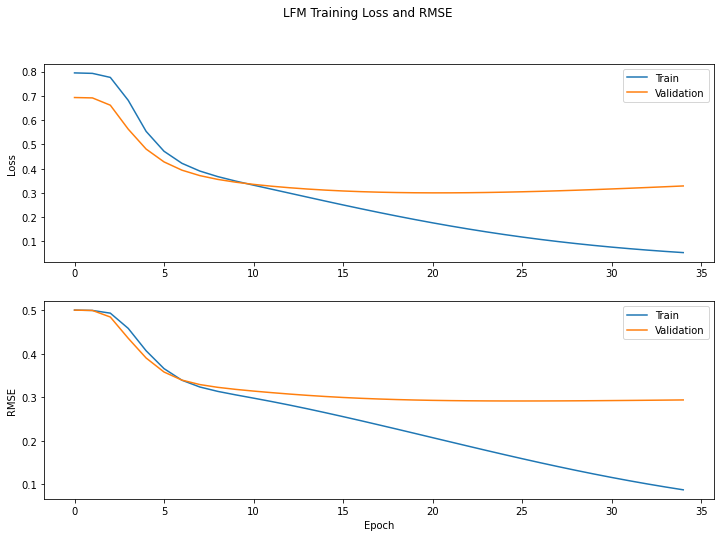

In [ ]:
fig = plt.figure(figsize=(12, 8))
fig.suptitle('LFM Training Loss and RMSE')

plt.subplot(211)
plt.plot(list(range(35)), history.history['loss'], label = 'Train')
plt.plot(list(range(35)), history.history['val_loss'], label = 'Validation')
plt.ylabel('Loss')
plt.legend()

plt.subplot(212)
plt.plot(list(range(35)), history.history['root_mean_squared_error'], label = 'Train')
plt.plot(list(range(35)), history.history['val_root_mean_squared_error'], label = 'Validation')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend()

plt.savefig('plots/basic_exp')

<a id=neg_samples><a>
## Negative samples

<a id=#0.5><a>
### Negative samples x0.5

In [ ]:
negative_train = train[train['rating'] == 0]
negative_train = negative_train.sample(negative_train.shape[0] // 2)
train_half = train.drop(negative_train.index)

In [ ]:
model = create_shallow_model(num_factors, num_users, num_artists)
optimizer = tf.keras.optimizers.Adam()
loss_fct = tf.keras.losses.BinaryCrossentropy(from_logits=False)
model.compile(optimizer = optimizer, loss = loss_fct, metrics = tf.keras.metrics.RootMeanSquaredError())

In [ ]:
# set binary labels, calculate weights
labels = train_half.rating>=threshold
y = train_half.rating
weights = tf.expand_dims(1. + 0.25*y, -1)

# fit model
history = model.fit(x=[train_half.user_email, train_half.artist_id],
                      y=labels,
                      sample_weight=weights,
                      epochs = epochs,
                      batch_size=batch_size,
                      validation_data=([valid.user_email, valid.artist_id],
                                       valid.rating>=threshold),
                      verbose = 0)


avg_test_loss = tf.keras.metrics.Mean()
test_rmse = tf.keras.metrics.RootMeanSquaredError()

test_step = create_test_step(model, loss_fct, avg_test_loss, test_rmse)
probs, test_loss, test_rmse = test_one_epoch(test_step, test_dataset, None, avg_test_loss, test_rmse, threshold, si=False, only_si=False)
print('Test loss:', test_loss)
print('Test RMSE:', test_rmse)

pred_ratings = test.copy()
pred_ratings['pred'] = probs
pred_ratings_dict = {}
for user, user_df in pred_ratings.groupby('user_email'):
  pred_ratings_dict[user] = np.stack([user_df['artist_id'].to_numpy(), user_df['pred'].to_numpy()])
prec, rec, _, _, _  = compute_metrics(test.drop(test[test.rating == 0].index), test['user_email'].unique(), pred_ratings_dict, k)

Test loss: 0.28261748
Test RMSE: 0.28587532
Computing precision & recall...



Computing normalized discounted cumulative gain...



Computing hit rate...



Computing average reciprocal hit ranking...




Metrics: 

Precision @ 10: 0.3239418088303455
Recall    @ 10: 0.6587231328279127
Ndcg @ 10: 0.7025162358543727
Hit rate: 3.2216557271653485
Arhr: 1.3600989966129273


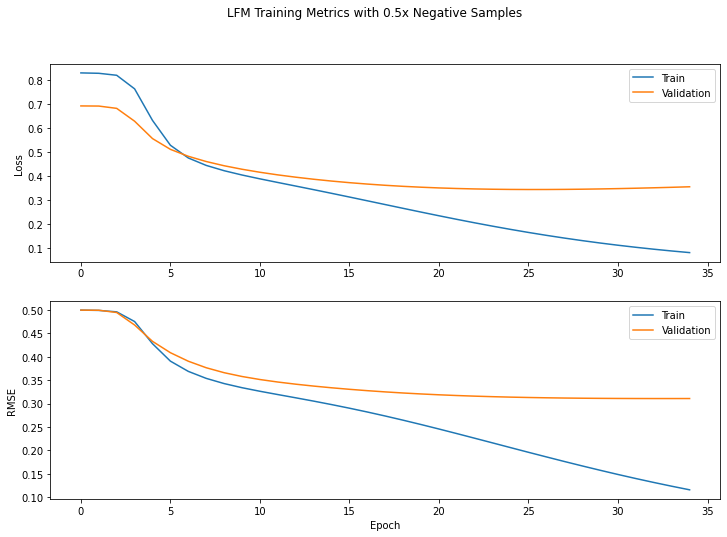

In [ ]:
fig = plt.figure(figsize=(12, 8))
fig.suptitle('LFM Training Metrics with 0.5x Negative Samples')

plt.subplot(211)
plt.plot(list(range(epochs)), history.history['loss'], label = 'Train')
plt.plot(list(range(epochs)), history.history['val_loss'], label = 'Validation')
plt.ylabel('Loss')
plt.legend()

plt.subplot(212)
plt.plot(list(range(epochs)), history.history['root_mean_squared_error'], label = 'Train')
plt.plot(list(range(epochs)), history.history['val_root_mean_squared_error'], label = 'Validation')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend()

plt.savefig('plots/05_neg_exp')

<a id=#2><a>
### Negative samples x2

In [ ]:
train_twice = pd.read_csv('lastfm-dataset-360K/train_twice.csv')
epochs = 15

In [ ]:
model = create_shallow_model(num_factors, num_users, num_artists)
optimizer = tf.keras.optimizers.Adam()
loss_fct = tf.keras.losses.BinaryCrossentropy(from_logits=False)
model.compile(optimizer = optimizer, loss = loss_fct, metrics = tf.keras.metrics.RootMeanSquaredError())

In [ ]:
# set binary labels, calculate weights
labels = train_twice.rating>=threshold
y = train_twice.rating
weights = tf.expand_dims(1. + 0.25*y, -1)

# fit model
history = model.fit(x=[train_twice.user_email, train_twice.artist_id],
                      y=labels,
                      sample_weight=weights,
                      epochs = epochs,
                      batch_size=batch_size,
                      validation_data=([valid.user_email, valid.artist_id],
                                       valid.rating>=threshold),
                      verbose = 0)


avg_test_loss = tf.keras.metrics.Mean()
test_rmse = tf.keras.metrics.RootMeanSquaredError()

test_step = create_test_step(model, loss_fct, avg_test_loss, test_rmse)
probs, test_loss, test_rmse = test_one_epoch(test_step, test_dataset, None, avg_test_loss, test_rmse, threshold, si=False, only_si=False)
print('Test loss:', test_loss)
print('Test RMSE:', test_rmse)

pred_ratings = test.copy()
pred_ratings['pred'] = probs
pred_ratings_dict = {}
for user, user_df in pred_ratings.groupby('user_email'):
  pred_ratings_dict[user] = np.stack([user_df['artist_id'].to_numpy(), user_df['pred'].to_numpy()])
prec, rec, _, _, _  = compute_metrics(test.drop(test[test.rating == 0].index), test['user_email'].unique(), pred_ratings_dict, k)

Test loss: 0.1260649
Test RMSE: 0.18272518
Computing precision & recall...



Computing normalized discounted cumulative gain...



Computing hit rate...



Computing average reciprocal hit ranking...




Metrics: 

Precision @ 10: 0.36317599389979516
Recall    @ 10: 0.7367590286403737
Ndcg @ 10: 0.7398175610315985
Hit rate: 3.611410971397814
Arhr: 1.546004370579174


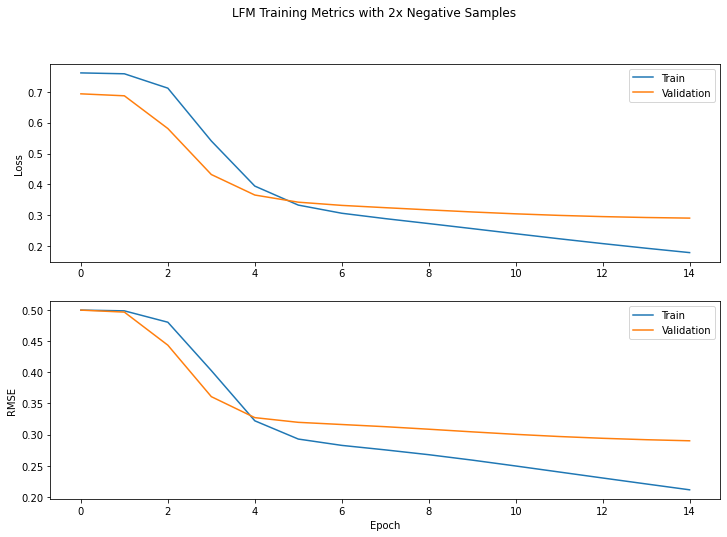

In [ ]:
fig = plt.figure(figsize=(12, 8))
fig.suptitle('LFM Training Metrics with 2x Negative Samples')

plt.subplot(211)
plt.plot(list(range(epochs)), history.history['loss'], label = 'Train')
plt.plot(list(range(epochs)), history.history['val_loss'], label = 'Validation')
plt.ylabel('Loss')
plt.legend()

plt.subplot(212)
plt.plot(list(range(epochs)), history.history['root_mean_squared_error'], label = 'Train')
plt.plot(list(range(epochs)), history.history['val_root_mean_squared_error'], label = 'Validation')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend()

plt.savefig('plots/2_neg_exp')

<a id=#3><a>
### Negative samples x3

In [ ]:
del train_twice
train_triple = pd.read_csv('lastfm-dataset-360K/train_triple.csv')

In [ ]:
model = create_shallow_model(num_factors, num_users, num_artists)
optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
model.compile(optimizer = optimizer, loss = loss_fct, metrics = tf.keras.metrics.RootMeanSquaredError())

In [ ]:
# set binary labels, calculate weights
labels = train_triple.rating>=threshold
y = train_triple.rating
weights = tf.expand_dims(1. + 0.25*y, -1)

# fit model
history = model.fit(x=[train_triple.user_email, train_triple.artist_id],
                      y=labels,
                      sample_weight=weights,
                      epochs = epochs,
                      batch_size=batch_size,
                      validation_data=([valid.user_email, valid.artist_id],
                                       valid.rating>=threshold))


avg_test_loss = tf.keras.metrics.Mean()
test_rmse = tf.keras.metrics.RootMeanSquaredError()

test_step = create_test_step(model, loss_fct, avg_test_loss, test_rmse)
probs, test_loss, test_rmse = test_one_epoch(test_step, test_dataset, None, avg_test_loss, test_rmse, threshold, si=False, only_si=False)
print('Test loss:', test_loss)
print('Test RMSE:', test_rmse)

pred_ratings = test.copy()
pred_ratings['pred'] = probs
pred_ratings_dict = {}
for user, user_df in pred_ratings.groupby('user_email'):
  pred_ratings_dict[user] = np.stack([user_df['artist_id'].to_numpy(), user_df['pred'].to_numpy()])
prec, rec, _, _, _  = compute_metrics(test.drop(test[test.rating == 0].index), test['user_email'].unique(), pred_ratings_dict, k)

Epoch 1/15
173/173 [==============================] - 63s 356ms/step - loss: 0.7439 - root_mean_squared_error: 0.5000 - val_loss: 0.6930 - val_root_mean_squared_error: 0.4999
Epoch 2/15
173/173 [==============================] - 62s 356ms/step - loss: 0.7386 - root_mean_squared_error: 0.4978 - val_loss: 0.6709 - val_root_mean_squared_error: 0.4888
Epoch 3/15
173/173 [==============================] - 61s 353ms/step - loss: 0.6236 - root_mean_squared_error: 0.4466 - val_loss: 0.4621 - val_root_mean_squared_error: 0.3786
Epoch 4/15
173/173 [==============================] - 62s 357ms/step - loss: 0.3754 - root_mean_squared_error: 0.3116 - val_loss: 0.3607 - val_root_mean_squared_error: 0.3281
Epoch 5/15
173/173 [==============================] - 61s 355ms/step - loss: 0.2868 - root_mean_squared_error: 0.2684 - val_loss: 0.3450 - val_root_mean_squared_error: 0.3245
Epoch 6/15
173/173 [==============================] - 61s 352ms/step - loss: 0.2631 - root_mean_squared_error: 0.2600 - val_l


Computing normalized discounted cumulative gain...



Computing hit rate...



Computing average reciprocal hit ranking...




Metrics: 

Precision @ 10: 0.37266569980413555
Recall    @ 10: 0.7561270460364774
Ndcg @ 10: 0.7465597201404549
Hit rate: 3.7056352137314414
Arhr: 1.585783857572455


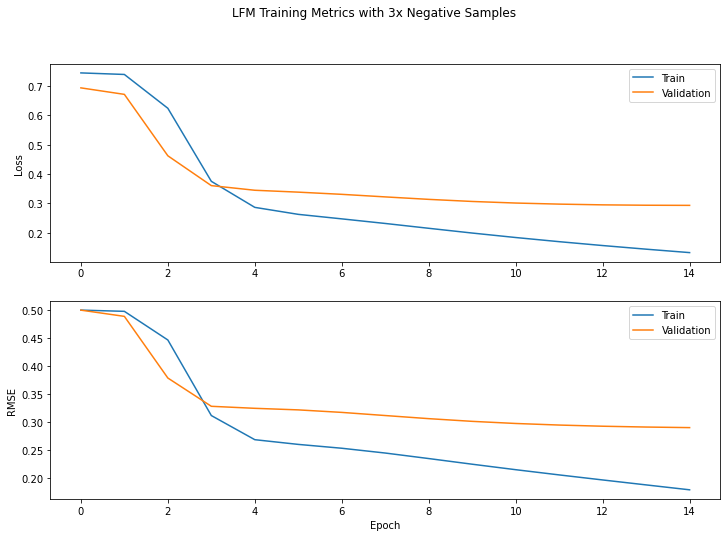

In [ ]:
fig = plt.figure(figsize=(12, 8))
fig.suptitle('LFM Training Metrics with 3x Negative Samples')

plt.subplot(211)
plt.plot(list(range(epochs)), history.history['loss'], label = 'Train')
plt.plot(list(range(epochs)), history.history['val_loss'], label = 'Validation')
plt.ylabel('Loss')
plt.legend()

plt.subplot(212)
plt.plot(list(range(epochs)), history.history['root_mean_squared_error'], label = 'Train')
plt.plot(list(range(epochs)), history.history['val_root_mean_squared_error'], label = 'Validation')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend()



plt.savefig('plots/3_neg_exp')